In [11]:
from tensorflow import keras 
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
# model expects rgb 180x180
inputs = keras.Input(shape=(180, 180, 3)) 
# rescale to [0,1] range by dividing by 255
x = layers.Rescaling(1./255)(inputs) 
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [4]:
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

### Preprocessing  
Data needs to be preprocesed into floating point tensors before being fed into network  
Currenty Jpeg
1. Read picture files
2. decode jpeg to rgb grids of pixels
3. convert to flooating point tenors
4. rescale pixel values (between 0 and 255) to the [0,1] interval  

Use keras utilities

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
import os, shutil, pathlib


new_base_dir = pathlib.Path('./datasets/catsvdogssmall/')

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## Tensorflow ```Dataset``` Objects
TensorFlow makes available the tf.data API to create efficient input pipelines for
machine learning models. Its core class is tf.data.Dataset.
A Dataset object is an iterator: you can use it in a for loop. It will typically return
batches of input data and labels. You can pass a Dataset object directly to the fit()
method of a Keras model.
The Dataset class handles many key features that would otherwise be cumbersome
to implement yourself—in particular, asynchronous data prefetching (preprocessing
the next batch of data while the previous one is being handled by the model, which
keeps execution flowing without interruptions).
The Dataset class also exposes a functional-style API for modifying datasets. Here’s
a quick example: let’s create a Dataset instance from a NumPy array of random numbers. We’ll consider 1,000 samples, where each sample is a vector of size 16:

Display shapes of data and labels yielded by Dataset


In [6]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


 ### Model Checkpoint
```ModelCheckpoint``` callback to save the model after each     epoch. We’ll configure it with the path specifying where to save the file, as well as the arguments save_best_only=True and monitor="val_loss": they tell the callback to only save a new file (overwriting any previous one) when the current value of the val_loss metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its bestperforming training epoch, in terms of its performance on the validation data. As a     result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.

In [7]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch.keras",
    save_best_only=True,
    monitor="val_loss")
]

In [9]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 89s 1s/step - loss: 0.8377 - accuracy: 0.5275 - val_loss: 0.6741 - val_accuracy: 0.5330
Epoch 2/30
63/63 [==============================] - 82s 1s/step - loss: 0.6980 - accuracy: 0.5380 - val_loss: 0.6820 - val_accuracy: 0.6020
Epoch 3/30
63/63 [==============================] - 78s 1s/step - loss: 0.6636 - accuracy: 0.6115 - val_loss: 0.6517 - val_accuracy: 0.6060
Epoch 4/30
63/63 [==============================] - 78s 1s/step - loss: 0.6236 - accuracy: 0.6655 - val_loss: 0.6782 - val_accuracy: 0.6430
Epoch 5/30
63/63 [==============================] - 77s 1s/step - loss: 0.5919 - accuracy: 0.6905 - val_loss: 0.5823 - val_accuracy: 0.6990
Epoch 6/30
63/63 [==============================] - 76s 1s/step - loss: 0.5518 - accuracy: 0.7170 - val_loss: 0.5871 - val_accuracy: 0.7080
Epoch 7/30
63/63 [==============================] - 77s 1s/step - loss: 0.5303 - accuracy: 0.7450 - val_loss: 0.5864 - val_accuracy: 0.6740
Epoch 8/30
63/63 [==

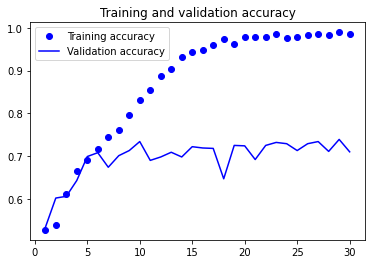

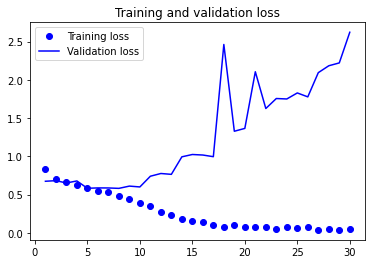

In [10]:

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [11]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 9s 268ms/step - loss: 0.6357 - accuracy: 0.6880
Test accuracy: 0.688


Plots show overfitting.  
With few training samples, overfitting biggest challenge.  
Use **Data Augmentation** to help with overfitting, used when processing images with DL models

#### Data Augmentiation  
Generate more training data from existing training samples via random transformations yielding believable looking images 

Use keras' ```data augmentation``` layers at start of model  
The following Sequential model chains several random image transformations. In our model, we’d include it right
before the Rescaling layer.

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Look at augmented images

In [ ]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(1): 
    for i in range(9):
        augmented_images = data_augmentation(images) 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) 
        plt.axis("off")


### New model with Image Augmentation

In [14]:
import tensorflow as tf

tf.get_logger().setLevel('ERROR')
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=["accuracy"])

Expect overfitting to occure much later so train for more epochs (100 vs 30)

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
63/63 [==============================] - 112s 2s/step - loss: 0.7400 - accuracy: 0.5070 - val_loss: 0.6913 - val_accuracy: 0.5630
Epoch 2/5
63/63 [==============================] - 99s 2s/step - loss: 0.6985 - accuracy: 0.5310 - val_loss: 0.6772 - val_accuracy: 0.5900
Epoch 3/5
63/63 [==============================] - 98s 2s/step - loss: 0.6915 - accuracy: 0.6000 - val_loss: 0.6725 - val_accuracy: 0.5660
Epoch 4/5
63/63 [==============================] - 103s 2s/step - loss: 0.6681 - accuracy: 0.6185 - val_loss: 0.6303 - val_accuracy: 0.6280
Epoch 5/5
63/63 [==============================] - 106s 2s/step - loss: 0.6527 - accuracy: 0.6440 - val_loss: 0.6451 - val_accuracy: 0.6270


## Results taken from text rather than running for 100 epochs

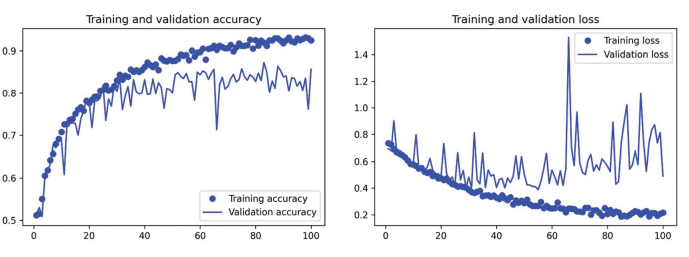

Thanks to data augmentation and dropout overfitting doesn't begin to occur until 60-70 epochs vs 10 for original model